In [58]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import load_img, img_to_array
from tensorflow import keras
from keras import layers, activations, losses, optimizers, metrics, callbacks, utils

In [4]:
input_dir = 'ch9/images/'
target_dir = 'ch9/annotations/trimaps/'

def get_paths(dir, ext):
    return sorted([os.path.join(dir, filename) for filename in os.listdir(dir) if filename.endswith(ext) and not filename.startswith('.')])

input_img_paths = get_paths(input_dir, '.jpg')
target_paths = get_paths(target_dir, '.png')

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

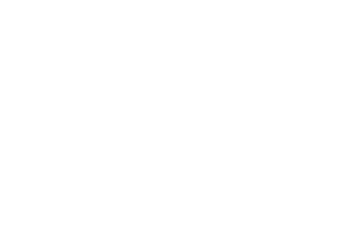

In [5]:
plt.axis('off')
plt.imshow(load_img(input_img_paths[9]))

def display_target(target_array):
    normalized_array = target_array.astype(np.int8) * 85
    plt.axis('off')
    plt.imshow(normalized_array)

a = load_img(target_paths[9], color_mode='grayscale')
b = img_to_array(a)
display_target(b)

In [6]:
img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_img(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(load_img(path, target_size=img_size, color_mode='grayscale'))
    img = img.astype(np.uint8) - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype=np.float32)
targets = np.zeros((num_imgs,) + img_size + (1,), dtype=np.uint8)
for i in range(num_imgs):
    input_imgs[i] = path_to_input_img(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.

In [50]:
num_val_samples = 1000

train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [60]:
def get_model(img_size, num_classes):
    inputs = layers.Input(img_size + (3,))
    x = layers.Rescaling(1/255)(inputs)

    x = layers.Conv2D(filters=64, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=128, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2D(filters=256, kernel_size=3, activation=activations.relu, padding='same')(x)

    x = layers.Conv2DTranspose(filters=256, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=3, activation=activations.relu, padding='same')(x)
    x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, activation=activations.relu, padding='same')(x)

    outputs = layers.Conv2D(filters=num_classes, kernel_size=3, activation=activations.softmax, padding='same')(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()
    

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 100, 64)      1792      
                                                                 
 conv2d_8 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_9 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_10 (Conv2D)          (None, 50, 50, 128)       147584    
                                                                 
 conv2d_11 (Conv2D)          (None, 25, 25, 256)       2951

In [61]:
model.compile(optimizer=optimizers.RMSprop(),
              loss=losses.SparseCategoricalCrossentropy(),
              metrics=[metrics.SparseCategoricalAccuracy()])

callback_list = [
    callbacks.ModelCheckpoint('oxford_seg', save_best_only='True')
]

history = model.fit(train_input_imgs, train_targets, epochs=50, callbacks=callback_list, batch_size=64, validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.9391 - sparse_categorical_accuracy: 0.5790INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 423s 4s/step - loss: 0.9391 - sparse_categorical_accuracy: 0.5790 - val_loss: 0.8888 - val_sparse_categorical_accuracy: 0.5800
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.8805 - sparse_categorical_accuracy: 0.5765INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 425s 4s/step - loss: 0.8805 - sparse_categorical_accuracy: 0.5765 - val_loss: 0.8610 - val_sparse_categorical_accuracy: 0.6030
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.8392 - sparse_categorical_accuracy: 0.6071INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 431s 4s/step - loss: 0.8392 - sparse_categorical_accuracy: 0.6071 - val_loss: 0.7804 - val_sparse_categorical_accuracy: 0.6646
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.8170 - sparse_categorical_accuracy: 0.6472INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 428s 4s/step - loss: 0.8170 - sparse_categorical_accuracy: 0.6472 - val_loss: 0.7682 - val_sparse_categorical_accuracy: 0.6882
Epoch 5/50
100/100 [==============================] - 426s 4s/step - loss: 0.7833 - sparse_categorical_accuracy: 0.6762 - val_loss: 0.7722 - val_sparse_categorical_accuracy: 0.6848
Epoch 6/50
100/100 [==============================] - ETA: 0s - loss: 0.7576 - sparse_categorical_accuracy: 0.6925INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 428s 4s/step - loss: 0.7576 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.7220 - val_sparse_categorical_accuracy: 0.7063
Epoch 7/50
100/100 [==============================] - 423s 4s/step - loss: 0.7541 - sparse_categorical_accuracy: 0.6915 - val_loss: 0.7329 - val_sparse_categorical_accuracy: 0.6999
Epoch 8/50
100/100 [==============================] - 428s 4s/step - loss: 0.7376 - sparse_categorical_accuracy: 0.6988 - val_loss: 0.7480 - val_sparse_categorical_accuracy: 0.6999
Epoch 9/50
100/100 [==============================] - ETA: 0s - loss: 0.7140 - sparse_categorical_accuracy: 0.7075INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 423s 4s/step - loss: 0.7140 - sparse_categorical_accuracy: 0.7075 - val_loss: 0.6456 - val_sparse_categorical_accuracy: 0.7366
Epoch 10/50
100/100 [==============================] - ETA: 0s - loss: 0.6916 - sparse_categorical_accuracy: 0.7170INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 427s 4s/step - loss: 0.6916 - sparse_categorical_accuracy: 0.7170 - val_loss: 0.6171 - val_sparse_categorical_accuracy: 0.7481
Epoch 11/50
100/100 [==============================] - 418s 4s/step - loss: 0.6687 - sparse_categorical_accuracy: 0.7277 - val_loss: 0.6552 - val_sparse_categorical_accuracy: 0.7343
Epoch 12/50
100/100 [==============================] - 420s 4s/step - loss: 0.6562 - sparse_categorical_accuracy: 0.7339 - val_loss: 0.6272 - val_sparse_categorical_accuracy: 0.7448
Epoch 13/50
100/100 [==============================] - ETA: 0s - loss: 0.6256 - sparse_categorical_accuracy: 0.7465INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 413s 4s/step - loss: 0.6256 - sparse_categorical_accuracy: 0.7465 - val_loss: 0.5648 - val_sparse_categorical_accuracy: 0.7712
Epoch 14/50
100/100 [==============================] - ETA: 0s - loss: 0.6179 - sparse_categorical_accuracy: 0.7511INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 415s 4s/step - loss: 0.6179 - sparse_categorical_accuracy: 0.7511 - val_loss: 0.5472 - val_sparse_categorical_accuracy: 0.7814
Epoch 15/50
100/100 [==============================] - 413s 4s/step - loss: 0.5900 - sparse_categorical_accuracy: 0.7620 - val_loss: 0.5523 - val_sparse_categorical_accuracy: 0.7776
Epoch 16/50
100/100 [==============================] - 414s 4s/step - loss: 0.5784 - sparse_categorical_accuracy: 0.7659 - val_loss: 0.5494 - val_sparse_categorical_accuracy: 0.7760
Epoch 17/50
100/100 [==============================] - ETA: 0s - loss: 0.5592 - sparse_categorical_accuracy: 0.7752INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 411s 4s/step - loss: 0.5592 - sparse_categorical_accuracy: 0.7752 - val_loss: 0.5170 - val_sparse_categorical_accuracy: 0.7922
Epoch 18/50
100/100 [==============================] - 414s 4s/step - loss: 0.5533 - sparse_categorical_accuracy: 0.7777 - val_loss: 0.5238 - val_sparse_categorical_accuracy: 0.7965
Epoch 19/50
100/100 [==============================] - 414s 4s/step - loss: 0.5508 - sparse_categorical_accuracy: 0.7792 - val_loss: 0.5201 - val_sparse_categorical_accuracy: 0.7940
Epoch 20/50
100/100 [==============================] - 415s 4s/step - loss: 0.5323 - sparse_categorical_accuracy: 0.7867 - val_loss: 0.5191 - val_sparse_categorical_accuracy: 0.7941
Epoch 21/50
100/100 [==============================] - 409s 4s/step - loss: 0.5180 - sparse_categorical_accuracy: 0.7932 - val_loss: 0.5192 - val_sparse_categorical_accuracy: 0.7898
Epoch 22/50
100/100 [==============================] - 410s 4s/step - loss: 0.5161 - sparse_categorica

INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 413s 4s/step - loss: 0.4823 - sparse_categorical_accuracy: 0.8096 - val_loss: 0.5033 - val_sparse_categorical_accuracy: 0.7995
Epoch 27/50
100/100 [==============================] - ETA: 0s - loss: 0.4716 - sparse_categorical_accuracy: 0.8127INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 416s 4s/step - loss: 0.4716 - sparse_categorical_accuracy: 0.8127 - val_loss: 0.4198 - val_sparse_categorical_accuracy: 0.8345
Epoch 28/50
100/100 [==============================] - 414s 4s/step - loss: 0.4633 - sparse_categorical_accuracy: 0.8171 - val_loss: 0.4514 - val_sparse_categorical_accuracy: 0.8197
Epoch 29/50
100/100 [==============================] - 412s 4s/step - loss: 0.4559 - sparse_categorical_accuracy: 0.8195 - val_loss: 0.4291 - val_sparse_categorical_accuracy: 0.8293
Epoch 30/50
100/100 [==============================] - 409s 4s/step - loss: 0.4416 - sparse_categorical_accuracy: 0.8260 - val_loss: 0.5537 - val_sparse_categorical_accuracy: 0.7776
Epoch 31/50
100/100 [==============================] - 412s 4s/step - loss: 0.4441 - sparse_categorical_accuracy: 0.8249 - val_loss: 0.4508 - val_sparse_categorical_accuracy: 0.8221
Epoch 32/50
100/100 [==============================] - 413s 4s/step - loss: 0.4303 - sparse_categorica

INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 413s 4s/step - loss: 0.4209 - sparse_categorical_accuracy: 0.8349 - val_loss: 0.4181 - val_sparse_categorical_accuracy: 0.8375
Epoch 35/50
100/100 [==============================] - 415s 4s/step - loss: 0.4132 - sparse_categorical_accuracy: 0.8377 - val_loss: 0.4214 - val_sparse_categorical_accuracy: 0.8342
Epoch 36/50
100/100 [==============================] - ETA: 0s - loss: 0.4014 - sparse_categorical_accuracy: 0.8428INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 414s 4s/step - loss: 0.4014 - sparse_categorical_accuracy: 0.8428 - val_loss: 0.3986 - val_sparse_categorical_accuracy: 0.8449
Epoch 37/50
100/100 [==============================] - ETA: 0s - loss: 0.4030 - sparse_categorical_accuracy: 0.8420INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 415s 4s/step - loss: 0.4030 - sparse_categorical_accuracy: 0.8420 - val_loss: 0.3915 - val_sparse_categorical_accuracy: 0.8484
Epoch 38/50
100/100 [==============================] - ETA: 0s - loss: 0.3987 - sparse_categorical_accuracy: 0.8441INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 416s 4s/step - loss: 0.3987 - sparse_categorical_accuracy: 0.8441 - val_loss: 0.3756 - val_sparse_categorical_accuracy: 0.8533
Epoch 39/50
100/100 [==============================] - 413s 4s/step - loss: 0.3897 - sparse_categorical_accuracy: 0.8474 - val_loss: 0.3789 - val_sparse_categorical_accuracy: 0.8541
Epoch 40/50
100/100 [==============================] - ETA: 0s - loss: 0.3826 - sparse_categorical_accuracy: 0.8504INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 412s 4s/step - loss: 0.3826 - sparse_categorical_accuracy: 0.8504 - val_loss: 0.3755 - val_sparse_categorical_accuracy: 0.8523
Epoch 41/50
100/100 [==============================] - 415s 4s/step - loss: 0.3797 - sparse_categorical_accuracy: 0.8521 - val_loss: 0.4035 - val_sparse_categorical_accuracy: 0.8456
Epoch 42/50
100/100 [==============================] - 413s 4s/step - loss: 0.3774 - sparse_categorical_accuracy: 0.8527 - val_loss: 0.3833 - val_sparse_categorical_accuracy: 0.8520
Epoch 43/50
100/100 [==============================] - 413s 4s/step - loss: 0.3679 - sparse_categorical_accuracy: 0.8559 - val_loss: 0.4063 - val_sparse_categorical_accuracy: 0.8408
Epoch 44/50
100/100 [==============================] - 416s 4s/step - loss: 0.3674 - sparse_categorical_accuracy: 0.8564 - val_loss: 0.4016 - val_sparse_categorical_accuracy: 0.8454
Epoch 45/50
100/100 [==============================] - ETA: 0s - loss: 0.3557 - sparse_categorical_acc

INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 413s 4s/step - loss: 0.3557 - sparse_categorical_accuracy: 0.8612 - val_loss: 0.3614 - val_sparse_categorical_accuracy: 0.8600
Epoch 46/50
100/100 [==============================] - ETA: 0s - loss: 0.3521 - sparse_categorical_accuracy: 0.8624INFO:tensorflow:Assets written to: oxford_seg/assets


INFO:tensorflow:Assets written to: oxford_seg/assets


100/100 [==============================] - 415s 4s/step - loss: 0.3521 - sparse_categorical_accuracy: 0.8624 - val_loss: 0.3492 - val_sparse_categorical_accuracy: 0.8641
Epoch 47/50
100/100 [==============================] - 416s 4s/step - loss: 0.3472 - sparse_categorical_accuracy: 0.8645 - val_loss: 0.3703 - val_sparse_categorical_accuracy: 0.8573
Epoch 48/50
100/100 [==============================] - 416s 4s/step - loss: 0.3431 - sparse_categorical_accuracy: 0.8660 - val_loss: 0.3513 - val_sparse_categorical_accuracy: 0.8644
Epoch 49/50
100/100 [==============================] - 410s 4s/step - loss: 0.3330 - sparse_categorical_accuracy: 0.8699 - val_loss: 0.4937 - val_sparse_categorical_accuracy: 0.7950
Epoch 50/50
100/100 [==============================] - 409s 4s/step - loss: 0.3315 - sparse_categorical_accuracy: 0.8707 - val_loss: 0.3526 - val_sparse_categorical_accuracy: 0.8637


array([[0.9390741 , 0.88876629],
       [0.8805415 , 0.86096197],
       [0.83924168, 0.78044951],
       [0.81700706, 0.76815701],
       [0.7833432 , 0.77215093],
       [0.75761366, 0.72204608],
       [0.75408262, 0.73291498],
       [0.73761982, 0.74798   ],
       [0.71402687, 0.64558405],
       [0.69156879, 0.61709154],
       [0.6686908 , 0.65516239],
       [0.65617114, 0.62721312],
       [0.62556529, 0.56477416],
       [0.61786807, 0.54716927],
       [0.59003311, 0.55229896],
       [0.57838124, 0.54942894],
       [0.55924791, 0.51698875],
       [0.55331272, 0.52382016],
       [0.55078149, 0.52009296],
       [0.53231651, 0.51912439],
       [0.51802838, 0.51921856],
       [0.51611251, 0.56756359],
       [0.50216943, 0.64025891],
       [0.48948139, 0.56325829],
       [0.48229966, 0.66710514],
       [0.48234436, 0.50333267],
       [0.47164971, 0.41976792],
       [0.46327701, 0.45139131],
       [0.45587468, 0.42911917],
       [0.44160897, 0.55368578],
       [0.

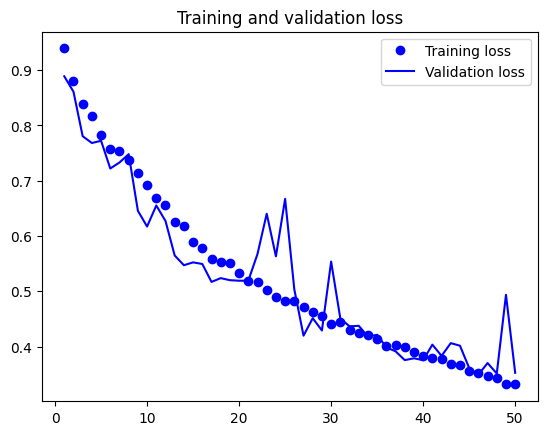

In [72]:
epochs = range(1, len(history.history['loss']) + 1)
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
np.array([history.history['loss'], history.history['val_loss']]).T